# Anomaly Detection for IoT Devices

A brief for this project.

### Getting all dependencies for creating a virtual envionment

In [71]:
%%bash
set -e

pip install virtualenv

# Create virtual environment
python3 -m virtualenv myenv
source ./myenv/bin/activate
./myenv/bin/pip install ipykernel
./myenv/bin/pip install numpy pandas scikit-learn matplotlib seaborn imblearn
./myenv/bin/pip freeze > requirements.txt
python3 -m ipykernel install --user --name=myenv --display-name "Python3 (myenv)"


created virtual environment CPython3.10.12.final.0-64 in 131ms
  creator CPython3Posix(dest=/home/joao/inatel/P10/C318/Project/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/joao/snap/code/174/.local/share/virtualenv)
    added seed packages: asttokens==2.4.1, comm==0.2.2, contourpy==1.3.1, cycler==0.12.1, debugpy==1.8.8, decorator==5.1.1, distlib==0.3.9, exceptiongroup==1.2.2, executing==2.1.0, filelock==3.16.1, fonttools==4.55.0, imbalanced_learn==0.12.4, imblearn==0.0, ipykernel==6.29.5, ipython==8.29.0, jedi==0.19.2, joblib==1.4.2, jupyter_client==8.6.3, jupyter_core==5.7.2, kiwisolver==1.4.7, matplotlib==3.9.2, matplotlib_inline==0.1.7, nest_asyncio==1.6.0, numpy==2.1.3, packaging==24.2, pandas==2.2.3, parso==0.8.4, pexpect==4.9.0, pillow==11.0.0, pip==24.3.1, platformdirs==4.3.6, prompt_toolkit==3.0.48, psutil==6.1.0, ptyprocess==0.7.0, pure_eval==0.2.3, pygments

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [73]:
def convert_timestamp(ts):
    # Convert timestamp to datetime
    dt = datetime.fromtimestamp(ts, tz=timezone.utc)
    # Format the datetime to the desired string format
    formatted = dt.strftime('%Y-%m-%d %H:%M:%S.') + f"{dt.microsecond // 1000:03d} {dt.strftime('%z')}"
    # Adjust timezone formatting to include the colon
    formatted = formatted[:-2] + ":" + formatted[-2:]
    return formatted

In [74]:
df_feature = pd.read_csv('./dataset/dvc_anomalo.csv')
df_feature.head()

,id,location,device,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704751249000,0.0,100.0,17898466.0,4585384.0,22516.0,23.0,0.0,0.0,140.0,18300.0,35.0
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704914640000,1.0,100.0,17907226.0,4586661.0,22442.0,649.0,145.0,-21.0,989.0,0.0,41.0
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704918241000,1.0,100.0,17921644.0,4588813.0,22564.0,647.0,145.0,-21.0,989.0,0.0,40.0
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704921842000,1.0,100.0,17936112.0,4591007.0,22564.0,648.0,145.0,-22.0,988.0,0.0,38.0
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704925442000,1.0,100.0,17950563.0,4593223.0,22717.0,644.0,145.0,-22.0,988.0,0.0,39.0


In [75]:
df_feature['timestamp'] = df_feature['timestamp'] / 1000.0
df_feature['timestamp'] = df_feature['timestamp'].apply(convert_timestamp)
df_feature.head()

,id,location,device,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-08 22:00:49.000 +00:00,0.0,100.0,17898466.0,4585384.0,22516.0,23.0,0.0,0.0,140.0,18300.0,35.0
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 19:24:00.000 +00:00,1.0,100.0,17907226.0,4586661.0,22442.0,649.0,145.0,-21.0,989.0,0.0,41.0
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 20:24:01.000 +00:00,1.0,100.0,17921644.0,4588813.0,22564.0,647.0,145.0,-21.0,989.0,0.0,40.0
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 21:24:02.000 +00:00,1.0,100.0,17936112.0,4591007.0,22564.0,648.0,145.0,-22.0,988.0,0.0,38.0
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 22:24:02.000 +00:00,1.0,100.0,17950563.0,4593223.0,22717.0,644.0,145.0,-22.0,988.0,0.0,39.0


In [76]:
df_target = pd.read_csv('./dataset/anomalo-events-sample.csv')
df_target.head()

,id,location,identification,nodeLabel,attr,value,timestamp
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00


In [77]:
matching_rows = pd.Series(index=df_feature.index)
matching_rows = df_feature['timestamp'].isin(df_target['timestamp'])
print(matching_rows.value_counts())

timestamp
False    1666
Name: count, dtype: int64


In [78]:
df_feature['timestamp'] = pd.to_datetime(df_feature['timestamp'])
df_feature.head()

,id,location,device,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-08 22:00:49+00:00,0.0,100.0,17898466.0,4585384.0,22516.0,23.0,0.0,0.0,140.0,18300.0,35.0
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 19:24:00+00:00,1.0,100.0,17907226.0,4586661.0,22442.0,649.0,145.0,-21.0,989.0,0.0,41.0
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 20:24:01+00:00,1.0,100.0,17921644.0,4588813.0,22564.0,647.0,145.0,-21.0,989.0,0.0,40.0
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 21:24:02+00:00,1.0,100.0,17936112.0,4591007.0,22564.0,648.0,145.0,-22.0,988.0,0.0,38.0
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 22:24:02+00:00,1.0,100.0,17950563.0,4593223.0,22717.0,644.0,145.0,-22.0,988.0,0.0,39.0


In [79]:
df_target['timestamp'] = pd.to_datetime(df_target['timestamp'])
df_target.head()

,id,location,identification,nodeLabel,attr,value,timestamp
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38+00:00
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38+00:00
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38+00:00
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38+00:00
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38+00:00


In [80]:
# # Ordenação
# df_feature = df_feature.sort_values('timestamp')
# df_target = df_target.sort_values('timestamp')

# # Limpando
# df_feature_cleaned = df_feature.dropna(subset=['state', 'uRms', 'iRms', 'luminosityLux', 'temperature'])
# df_target_cleaned = df_target.drop_duplicates(subset='timestamp', keep='first')
# df_target_cleaned = df_target_cleaned.dropna(subset=['nodeLabel', 'timestamp'])

# # Tolerance
# tolerance=pd.Timedelta('10 min')

# # Merge baseado em proximidade
# df_state = pd.merge_asof(
#     df_feature_cleaned,
#     df_target_cleaned[['timestamp', 'attr']],
#     on='timestamp',
#     direction='nearest',
#     tolerance=tolerance
# )

# # Remover duplicatas com base no timestamp, mantendo a primeira ocorrência
# df_state = df_state.drop_duplicates(subset='timestamp', keep='first')
# # Adicionando a flag de anomalia
# df_state['is_anomalous'] = df_state['attr'].notna()
# df_state.to_csv(path_or_buf='combined.csv')


# Ordenação
df_feature = df_feature.sort_values('timestamp')
df_target = df_target.sort_values('timestamp')

# Limpando
df_feature_cleaned = df_feature.dropna(subset=['state', 'uRms', 'iRms', 'luminosityLux', 'temperature'])
df_target_cleaned = df_target.drop_duplicates(subset='timestamp', keep='first')
df_target_cleaned = df_target_cleaned.dropna(subset=['nodeLabel', 'timestamp'])

# Tolerancia
tolerance = pd.Timedelta('1 hour')

# Merge com direção forward
df_state_forward = pd.merge_asof(
    df_feature_cleaned,
    df_target_cleaned[['timestamp', 'attr']],
    on='timestamp',
    direction='forward',
    tolerance=tolerance
)

# Merge com direção backward
df_state_backward = pd.merge_asof(
    df_feature_cleaned,
    df_target_cleaned[['timestamp', 'attr']],
    on='timestamp',
    direction='backward',
    tolerance=tolerance
)

# Concatenando os resultados
df_state = pd.concat([df_state_forward, df_state_backward])

# Remover duplicatas com base no timestamp, mantendo a primeira ocorrência
df_state = df_state.drop_duplicates(subset='timestamp', keep='first')

# Adicionando a flag de anomalia
df_state['is_anomalous'] = df_state['attr'].notna()

# Salvar em CSV
df_state.to_csv(path_or_buf='combined.csv')

# Exibir a quantidade de valores de 'is_anomalous'
print(df_state['is_anomalous'].value_counts())


is_anomalous
False    1462
True      203
Name: count, dtype: int64


In [81]:
df_state['is_anomalous'].value_counts()

is_anomalous
False    1462
True      203
Name: count, dtype: int64

In [82]:
df = df_state.copy()
# Exibe o DataFrame limpo
df.head()

,id,location,device,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature,attr,is_anomalous
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-08 22:00:49+00:00,0.0,100.0,17898466.0,4585384.0,22516.0,23.0,0.0,0.0,140.0,18300.0,35.0,NaN,False
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 19:24:00+00:00,1.0,100.0,17907226.0,4586661.0,22442.0,649.0,145.0,-21.0,989.0,0.0,41.0,NaN,False
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 20:24:01+00:00,1.0,100.0,17921644.0,4588813.0,22564.0,647.0,145.0,-21.0,989.0,0.0,40.0,NaN,False
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 21:24:02+00:00,1.0,100.0,17936112.0,4591007.0,22564.0,648.0,145.0,-22.0,988.0,0.0,38.0,NaN,False
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 22:24:02+00:00,1.0,100.0,17950563.0,4593223.0,22717.0,644.0,145.0,-22.0,988.0,0.0,39.0,NaN,False


In [83]:
dfIforest_X = df.copy()
dfIforest_X.columns

Index(['id', 'location', 'device', 'timestamp', 'state', 'dimmer',
       'accActiveEnergy', 'accReactiveEnergy', 'uRms', 'iRms', 'activePotency',
       'reactivePotency', 'potencyFactor', 'luminosityLux', 'temperature',
       'attr', 'is_anomalous'],
      dtype='object')

In [84]:
dfIforest_X = dfIforest_X.drop(columns=['id', 'location', 'device', 'timestamp', 'dimmer',
       'accActiveEnergy', 'accReactiveEnergy', 'activePotency',
       'reactivePotency', 'potencyFactor', 'attr', 'is_anomalous'])

In [85]:
dfIforest_Y = df['is_anomalous'].copy()

In [86]:
dfIforest_X.head()

,state,uRms,iRms,luminosityLux,temperature
0,0.0,22516.0,23.0,18300.0,35.0
1,1.0,22442.0,649.0,0.0,41.0
2,1.0,22564.0,647.0,0.0,40.0
3,1.0,22564.0,648.0,0.0,38.0
4,1.0,22717.0,644.0,0.0,39.0


In [87]:
dfIforest_Y.value_counts()

is_anomalous
False    1462
True      203
Name: count, dtype: int64

In [88]:
dfIforest_Y = pd.Series(np.where(dfIforest_Y, -1, 1), index=dfIforest_Y.index)

In [89]:
dfIforest_Y.value_counts()

 1    1462
-1     203
Name: count, dtype: int64

In [90]:
X_train, X_test, Y_train, Y_test = train_test_split(dfIforest_X, dfIforest_Y, test_size=0.2, random_state=42)

In [91]:
X_train.shape

(1332, 5)

In [92]:
Y_train.shape

(1332,)

In [93]:
X_test.shape

(333, 5)

In [94]:
Y_test.shape

(333,)

In [95]:
Y_test.value_counts()

 1    290
-1     43
Name: count, dtype: int64

In [96]:
Y_train.value_counts()

 1    1172
-1     160
Name: count, dtype: int64

In [97]:
# Criando a função de scorer personalizada (com base no classification_report)
def custom_scorer(y_true, y_pred):
    # Manter o valor de 1 como normal e -1 como anômalo, já que estamos tratando de rótulos do tipo +1 e -1
    y_pred = np.where(y_pred == 1, 1, -1)  # Certificar-se de que os rótulos estão como +1 e -1
    return classification_report(y_true, y_pred, output_dict=True)['f1']


In [98]:
def train(X_train, Y_train, X_test, Y_test):
    model = IsolationForest(random_state=42)

    param_grid = {
        'n_estimators': [50, 100, 200],  # Number of trees
        'max_samples': ['auto', 0.5, 0.7],  # Fraction of samples to use for fitting each tree
        'contamination': ['auto', 0.01, 0.05, 0.1],  # Fraction of outliers
        'max_features': [1.0, 0.5]  # Number of features to consider when splitting a node
    }

    scorer = make_scorer(custom_scorer, greater_is_better=True)

    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring=scorer)

    # Fit
    grid_search.fit(X_train)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    return best_model, best_params

In [99]:
def evaluate(y_pred, y_test):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

In [100]:
best_model, best_params = train(X_train, Y_train, X_test, Y_test)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.3s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.4s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=100; total ti

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=200; total ti

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.6s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=100; total ti

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=50; total time=

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.6s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=100; total t

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=200; total time=

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.6s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=50; total ti

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.3s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.6s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=200; total 

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.6s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=200; total tim

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.7s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[C

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.6s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.7s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s

[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.6s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[C

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

In [101]:
y_pred = best_model.predict(X_test)
evaluate(y_pred, Y_test)


Classification Report:
              precision    recall  f1-score   support

          -1       0.19      0.42      0.26        43
           1       0.90      0.74      0.81       290

    accuracy                           0.70       333
   macro avg       0.54      0.58      0.54       333
weighted avg       0.80      0.70      0.74       333

Confusion Matrix:
[[ 18  25]
 [ 76 214]]


Matriz de Confusão:
[[ 18  25]
 [ 76 214]]


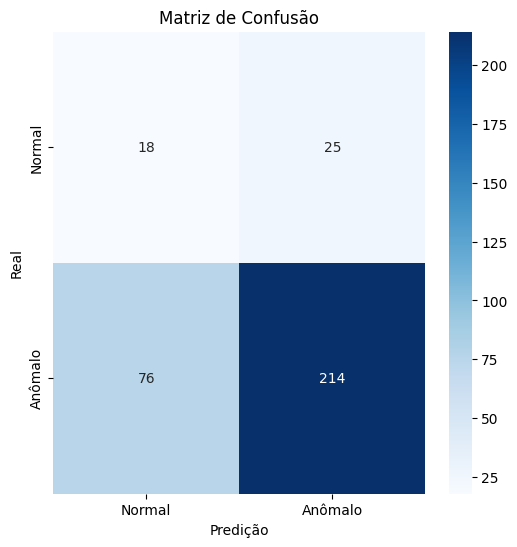

In [102]:
# Gerando a matriz de confusão
cm = confusion_matrix(Y_test, y_pred)

# Exibindo a matriz de confusão com labels
print("Matriz de Confusão:")
print(cm)

# Plotando a matriz de confusão com seaborn
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Anômalo"], yticklabels=["Normal", "Anômalo"])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [103]:
smote = SMOTE(random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [104]:
best_model, best_params = train(X_train_resampled, Y_train_resampled, X_test, Y_test)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,


[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=50; total 

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.6s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=100; total time=

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.6s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.6s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=100; total t

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.4s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.6s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=auto, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.4s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=100; total ti

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=200; total tim

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.6s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=50; total t

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.01, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.8s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.01, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=100; total ti

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.6s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.7, n_estimators=200; total ti

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.6s
[CV] END contamination=0.01, max_features=0.5, max_samples=0.5, n_estimators=200; total time

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=100; total time= 

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.4s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.6s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.05, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.6s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.6s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.2s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=1.0, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=50; total time=   0.1s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.05, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.6s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=0.5, max_samples=auto, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=100; total time=   0.3s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=50; total time=   0.1s

/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.4s
[CV] END contamination=0.1, max_features=1.0, max_samples=0.7, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.5, n_estimators=200; total time=   0.5s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=100; total time=   0.2s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.3s
[CV] END contamination=0.1, max_features=0.5, max_samples=0.7, n_estimators=200; total time=   0.3s


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 969, in _score
    scores = scorer(estimator,

In [105]:
y_pred = best_model.predict(X_test)
evaluate(y_pred, Y_test)

Classification Report:
              precision    recall  f1-score   support

          -1       0.15      0.23      0.18        43
           1       0.88      0.80      0.84       290

    accuracy                           0.73       333
   macro avg       0.51      0.52      0.51       333
weighted avg       0.78      0.73      0.75       333

Confusion Matrix:
[[ 10  33]
 [ 58 232]]
